# Quiz 3 - Port Logistics - Computer Vision

You have been tasked by a busy port to count the number of ships that arrive each day and classify them by type. The port wants to improve its operational efficiency by accurately tracking the arrival and departure of each ship and identifying trends in traffic patterns.

To achieve this, the port has installed a camera at a strategic location overlooking the point where ships arrive. The camera is capable of capturing high-resolution images and transmitting them to a computer for analysis.

Your job is to put the skills you learned at SCM.256, to develop an model that can accurately identify each ship in the images and categorize it by type such as container ships, tankers and cruise ships.

As you learned in class computer vision can be used to analyze the incoming images in real-time and count the number of ships by type. This data can then be stored and analyzed to identify trends and patterns in traffic over time.

To accomplish this task, you have trained a computer vision model using a large dataset of labeled ship images. The model could be trained to recognize various features of each ship, such as its size, shape, color, and other distinguishing characteristics. First you applied transfer learning with the InceptionResNetV2 model as the base model and finally you implemented your own convolutional network.



---
## Loading the Data

First we download the data with the ship photos that have been labeled with the ship type, as Container ship, Cruise Ship, Warship, RORO or Tanker.

In [1]:
!curl -L "https://www.dropbox.com/s/34cny2p6m1dug49/ShipClassification.v4i.tfrecord.zip?dl=1" > roboflow.zip; unzip -o roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     21      0 --:--:-- --:--:-- --:--:--    21
100   363  100   363    0     0    306      0  0:00:01  0:00:01 --:--:--   306
100 82.2M  100 82.2M    0     0  30.0M      0  0:00:02  0:00:02 --:--:-- 76.2M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Ships.tfrecord     
 extracting: test/Ships_label_map.pbtxt  
   creating: train/
 extracting: train/Ships.tfrecord    
 extracting: train/Ships_label_map.pbtxt  
   creating: valid/
 extracting: valid/Ships.tfrecord    
 extracting: valid/Ships_label_map.pbtxt  


## Setting Up the Workspace

We import the modules that we need and define a function that loads the TFRecords into a useable dataset for Tensorflow.

In [2]:
# Imports

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Define the input function
def read_tf_records(tfrecord_path, batch_size):
    # Create a TFRecordDataset object
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
    }


    # Parse the record into tensors
    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    # Apply the parse function to every record
    dataset = dataset.map(_parse_function)
    # Decode the image
    def decode_image(record):
        image = tf.image.decode_jpeg(record['image/encoded'], channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (224, 224))
        image = tf.reshape(image, [-1, 224, 224, 3])
        label = tf.sparse.to_dense(record['image/object/class/label'])

        label = tf.reduce_max(label)
        label = tf.maximum(1, tf.reduce_max(tf.cast(label, tf.int32)))-1
        #Convert label into binary classification whether the box has a label
        label = tf.reshape(label, (-1,1))
        return image, label

    # Apply the decode_image function to every record
    dataset = dataset.map(decode_image)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Return the dataset
    return dataset

ds_train = read_tf_records('train/Ships.tfrecord',128)
ds_valid = read_tf_records('valid/Ships.tfrecord',128)
ds_test = read_tf_records('test/Ships.tfrecord',128)

If we count the number of photos in our data-set can see that our classification problem is balanced

In [3]:
CLASSES = ['Container ship','Cruise Ship','Warship','RORO','Tanker']

counts = {}
for (record, label) in ds_train.take(50000):
  if int(label[0][0]) not in counts:
    counts[int(label[0][0])] = 0
  counts[int(label[0][0])] += 1
for (record, label) in ds_valid.take(50000):
  if int(label[0][0]) not in counts:
    counts[int(label[0][0])] = 0
  counts[int(label[0][0])] += 1
for (record, label) in ds_test.take(50000):
  if int(label[0][0]) not in counts:
    counts[int(label[0][0])] = 0
  counts[int(label[0][0])] += 1

dict([(CLASSES[i], count) for i, count in counts.items()])

{'Tanker': 885,
 'Cruise Ship': 420,
 'RORO': 766,
 'Warship': 732,
 'Container ship': 918}

To get a view of the images we can use the cell below to plot some of the photos. 

In [4]:
ds_iter = iter(ds_train)

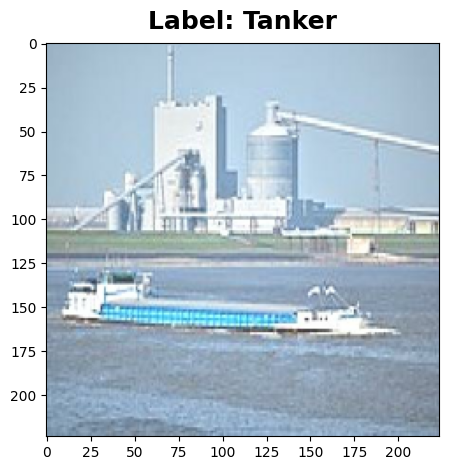

In [5]:
image, label = next(ds_iter)

# Plot the image
plt.imshow(image.numpy()[0])
plt.title(f"Label: {CLASSES[label[0][0]]}")
plt.show()

---
# Transfer Learning with Pre-Trained Base

## 1) Define Model

As mentioned first we will create a model with transfer learning based on the InceptionResNetV2 convolutional network that is pretrained on more than a million images from the ImageNet database.
We ensure that TensorFlow does not try to do any training on the layers provided by the pretrained base.

In [6]:
pretrained_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

pretrained_base.trainable = False


219055592/219055592 [==============================] - 1s 0us/step


Now that the base is defined to do the feature extraction, we created a head of two `Dense` layers to perform the classification.

In [7]:
# Create a head of Dense layers to perform the classification
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation='softmax')  
])


## 2) Compile and Train the Model 

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **classification** problem: Container ship is 0, Cruise Ship is 1,Warship is 2, RORO is 3, Tanker is 4. You picked sparse categorical crossentropy as the loss function and  sparse categorical accuracy metric for as the metric. These behave the similar to what you saw for binary classification in class.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

To avoid overfitting and wasting resources on unnecessary training, you defined a early stopping callback, to stop training once the validation loss function stops improving.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True,
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[early_stopping],
)


Epoch 1/30
3232/3232 [==============================] - 105s 26ms/step - loss: 0.8854 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.7375
Epoch 2/30
3232/3232 [==============================] - 89s 28ms/step - loss: 0.5973 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.8142
Epoch 3/30
3232/3232 [==============================] - 80s 25ms/step - loss: 0.4783 - sparse_categorical_accuracy: 0.8329 - val_loss: 0.7217 - val_sparse_categorical_accuracy: 0.8289
Epoch 4/30
3232/3232 [==============================] - 81s 25ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.8682 - val_loss: 0.7045 - val_sparse_categorical_accuracy: 0.8348
Epoch 5/30
3232/3232 [==============================] - 84s 26ms/step - loss: 0.3143 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.8462 - val_sparse_categorical_accuracy: 0.8289
Epoch 6/30
3232/3232 [==============================] - 83s 26ms/step - loss: 0

Now we plot the loss and metric functions.

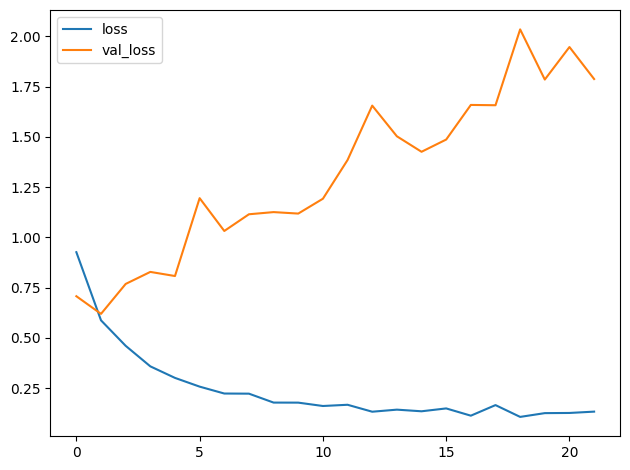

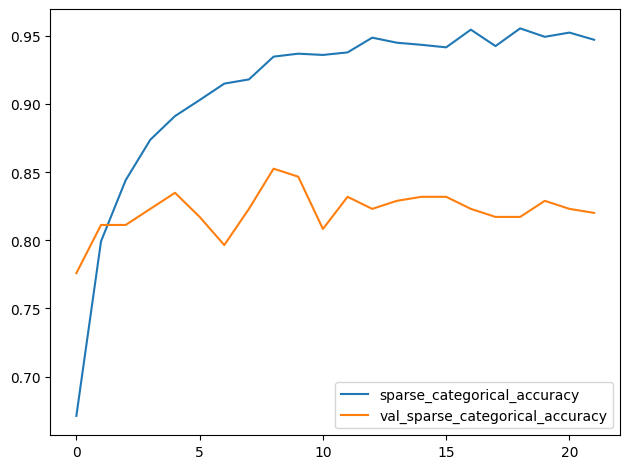

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

#### Q: *How would you interpret these training curves?* 

---
# Design a Custom Convnet

Let's design a convolutional network with a block architecture like we saw in class.




## 1) Define Model 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(CLASSES)

model = keras.Sequential([
    layers.InputLayer(input_shape=[224, 224, 3]),

    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation='softmax')  
])



## 2) Compile and Train the Model 

To prepare for training, compile the model with an appropriate loss and accuracy metric.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

Finally, let's test the performance of this new model. Run the next cell to fit the model to the training set.

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
)

Epoch 1/25
3232/3232 [==============================] - 22s 6ms/step - loss: 1.4513 - sparse_categorical_accuracy: 0.3567 - val_loss: 1.1693 - val_sparse_categorical_accuracy: 0.5487
Epoch 2/25
3232/3232 [==============================] - 17s 5ms/step - loss: 0.8508 - sparse_categorical_accuracy: 0.6754 - val_loss: 1.1291 - val_sparse_categorical_accuracy: 0.6165
Epoch 3/25
3232/3232 [==============================] - 17s 5ms/step - loss: 0.4032 - sparse_categorical_accuracy: 0.8527 - val_loss: 1.4706 - val_sparse_categorical_accuracy: 0.6431
Epoch 4/25
3232/3232 [==============================] - 17s 5ms/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9369 - val_loss: 1.7446 - val_sparse_categorical_accuracy: 0.6195
Epoch 5/25
3232/3232 [==============================] - 17s 5ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.9623 - val_loss: 2.2207 - val_sparse_categorical_accuracy: 0.5782
Epoch 6/25
3232/3232 [==============================] - 17s 5ms/step - loss: 0.0902 -

And now run the cell below to plot the loss and metric curves for this training run.

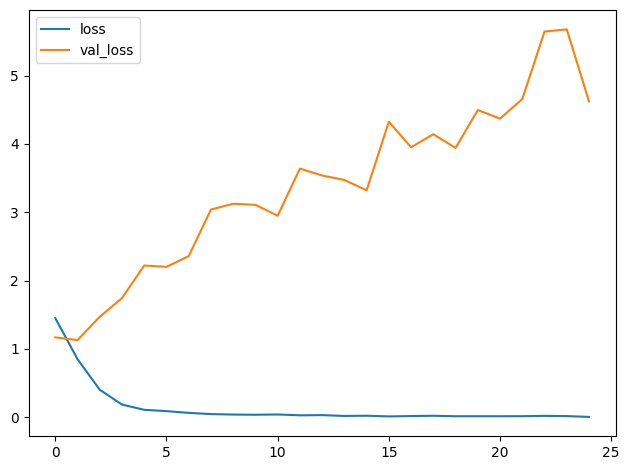

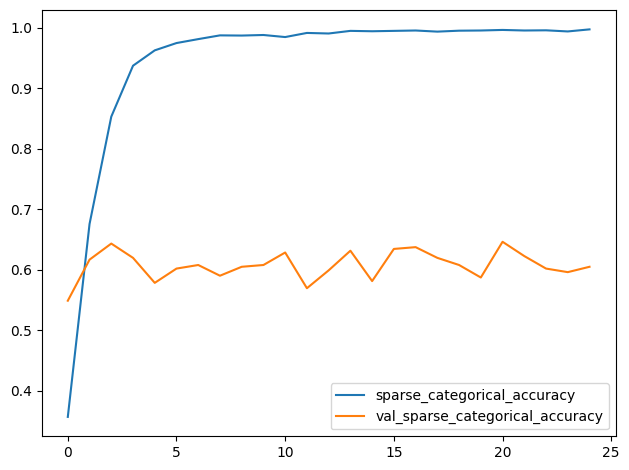

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

### Q: *How would you interpret these training curves?*

---
# Data Augmentation 


Run the cell below to set everything up!

## 1) Define Model 

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[224, 224, 3]),

    # Data Augmentation 
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),

    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation='softmax')  
])


## 2) Compile and Train the Model 

Now we'll train the model. Run the next cell to compile it with a loss and accuracy metric and fit it to the training set.

Epoch 1/25
3232/3232 [==============================] - 21s 6ms/step - loss: 1.4796 - sparse_categorical_accuracy: 0.3438 - val_loss: 1.2591 - val_sparse_categorical_accuracy: 0.4838
Epoch 2/25
3232/3232 [==============================] - 19s 6ms/step - loss: 1.2010 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.0051 - val_sparse_categorical_accuracy: 0.6077
Epoch 3/25
3232/3232 [==============================] - 18s 6ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.5944 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.6490
Epoch 4/25
3232/3232 [==============================] - 22s 7ms/step - loss: 0.9257 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.9451 - val_sparse_categorical_accuracy: 0.6519
Epoch 5/25
3232/3232 [==============================] - 19s 6ms/step - loss: 0.8603 - sparse_categorical_accuracy: 0.6640 - val_loss: 1.0077 - val_sparse_categorical_accuracy: 0.6549
Epoch 6/25
3232/3232 [==============================] - 19s 6ms/step - loss: 0.7937 -

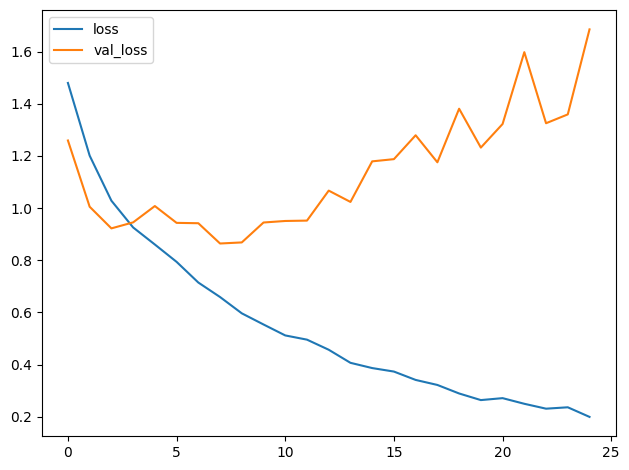

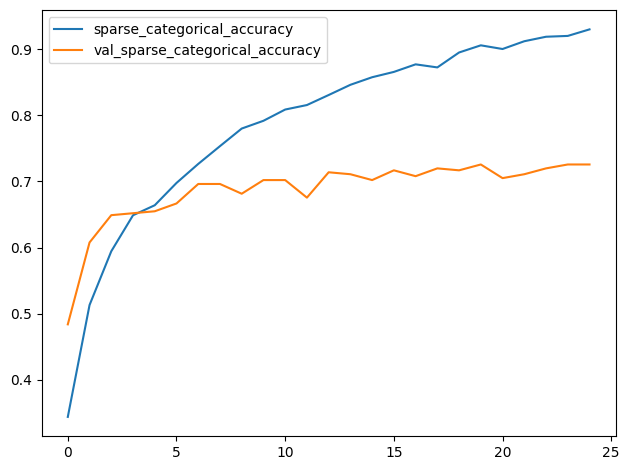

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

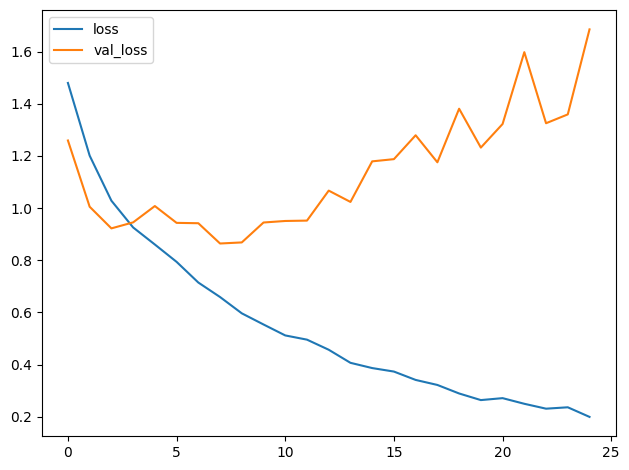

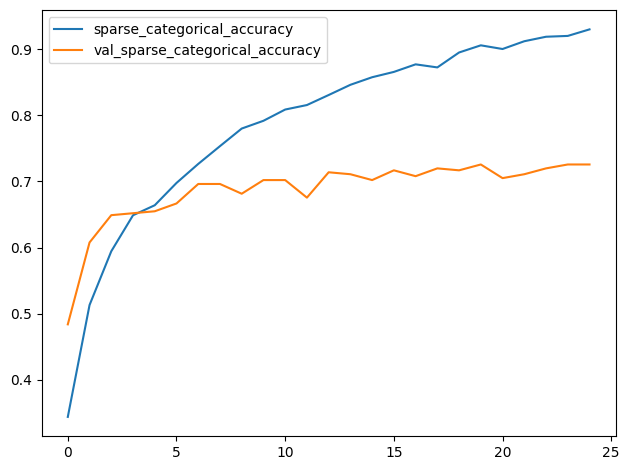

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

#### Q. *How would you interpret these training curves?*

# *PLEASE UPLOAD YOUR NOTEBOOK TO CANVAS*